In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
def process_images(img1_path, img2_path, threshold=0.75):
  img1 = cv2.imread(img1_path)
  img2 = cv2.imread(img2_path)

  gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  sift = cv2.SIFT_create()

  kp1, des1 = sift.detectAndCompute(gray1, None)
  kp2, des2 = sift.detectAndCompute(gray2, None)
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1, des2, k=2)

  # Lowe's ratio test
  good_matches = []
  for m, n in matches:
      if m.distance < threshold * n.distance:
          good_matches.append(m)
  return format_matches(kp1, kp2, good_matches), img1, img2

def format_matches(kp1, kp2, good_matches):
  pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  return np.array((pts1, pts2)).reshape(2, -1, 2)

def choose_n_matches(matches, n):
  return matches[:, np.random.choice(np.arange(0, matches.shape[1]), size=n, replace=False)].reshape(-1, n, 2)

def generate_row(m):
    x, y = m[0]
    x_prime, y_prime = m[1]
    arr = np.zeros((2, 9))
    arr[0] = [x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime, -x_prime]
    arr[1] = [0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime, -y_prime]
    return arr

def generate_A(matches, n):
  rows = []
  c_m = choose_n_matches(np.array(f_m), n)
  for i in range(c_m.shape[1]):
    rows.append(generate_row(c_m[:, i]))
  return np.concatenate(rows, axis=0)

def solve_A(A):
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]
    return h

def get_homography(matches, n):
  H  = solve_A(generate_A(matches, n)).reshape(3, 3)
  return H / H[2, 2]

def count_inliers(H, src_points, dst_points, threshold):
    """
    Counts the number of inliers given a homography matrix, source points, destination points, and a pixel threshold.

    Parameters:
    - H: 3x3 homography matrix
    - src_points: Nx2 array of source points
    - dst_points: Nx2 array of destination points
    - threshold: pixel threshold to consider a point as an inlier

    Returns:
    - inliers_count: number of inliers
    - inliers: indices of the inliers
    """
    src_points_homogeneous = np.hstack([src_points, np.ones((src_points.shape[0], 1))])
    transformed_points_homogeneous = (H @ src_points_homogeneous.T).T
    transformed_points = transformed_points_homogeneous[:, :2] / transformed_points_homogeneous[:, 2, np.newaxis]

    distances = np.linalg.norm(transformed_points - dst_points, axis=1)
    inliers = np.where(distances < threshold)[0]
    inliers_count = len(inliers)

    return inliers_count, inliers


def warp_image(img1, img2, H):
  height, width, _ = img2.shape  # Dimensions of the destination image
  warped_image = cv2.warpPerspective(img1, H, (width, height))

  # Visualize the result
  plt.figure(figsize=(15, 10))

  # Show destination image
  plt.subplot(1, 3, 1)
  plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
  plt.title("Destination Image")

  # Show source image
  plt.subplot(1, 3, 2)
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
  plt.title("Source Image")

  # Show warped image
  plt.subplot(1, 3, 3)
  plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
  plt.title("Warped Source Image")

  plt.show()

def my_ransac(img1_path, img2_path, threshold, wait_rounds = 100):
  max_H = None
  max_cnt = 0
  f_m, img1, img2 = process_images(img1_path, img2_path, threshold)
  src_points, dst_points = f_m[0], f_m[1]
  count = 0
  while(True):
    H = get_homography(f_m, 4)
    cnt, arr = count_inliers(H, src_points, dst_points, 5.0)
    if max_cnt < cnt:
      max_cnt = cnt
      max_H = H
      count = 0
    else:
      count += 1
      if count == wait_rounds:
        break
  return max_cnt, max_H

def optim_my_ransac(img1_path, img2_path):
  max_H = None
  max_cnt = 0
  lin = np.linspace(0.95, 0.5, 10)
  img1 = cv2.imread(img1_path)
  img2 = cv2.imread(img2_path)
  for threshold in lin:
    cnt, H = my_ransac(img1_path, img2_path, threshold)
    if max_cnt < cnt:
      max_cnt = cnt
      max_H = H
  warp_image(img1, img2, max_H)
  return max_cnt, max_H

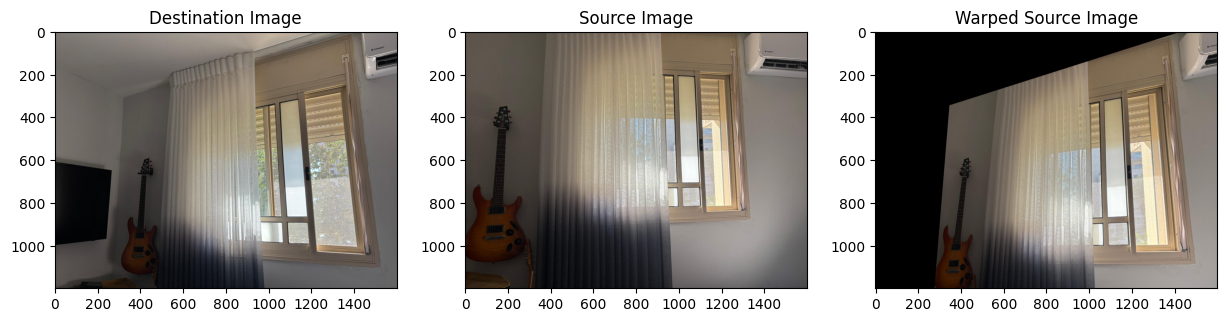

(20,
 array([[ 4.37204919e-01, -8.78647454e-02,  3.47951555e+02],
        [-2.62210277e-01,  7.09825254e-01,  3.46446548e+02],
        [-2.70434838e-04, -7.81778180e-05,  1.00000000e+00]]))

In [ ]:
optim_my_ransac('a.jpeg', 'b.jpeg')